In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import alexnet

from lib.datasets import datasets
from lib.utils import train, alex_classifier, pac_label_to_string, save_model, load_model, list_models

cuda = torch.cuda.is_available()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# PACS ART

In [2]:
ds = datasets()
ds.create_dataset('pacs')
batch_loader = ds.batch_loader(256)

Training the model!
Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
You can interrupt it at any time.
----------------------------------------------------------
After epoch  1 | valid err rate: 66.70% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate: 32.91% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate: 19.78% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate: 13.38% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  9.

----------------------------------------------------------
After epoch 46 | valid err rate:  2.25% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 47 | valid err rate:  2.10% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 48 | valid err rate:  2.05% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 49 | valid err rate:  2.29% | doing  50 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.29 | err rate  8.00%
----------------------------------------------------------
After epoch 50 | valid err rate:  2.44% | doing  50 epochs
----------------------------------------------------------


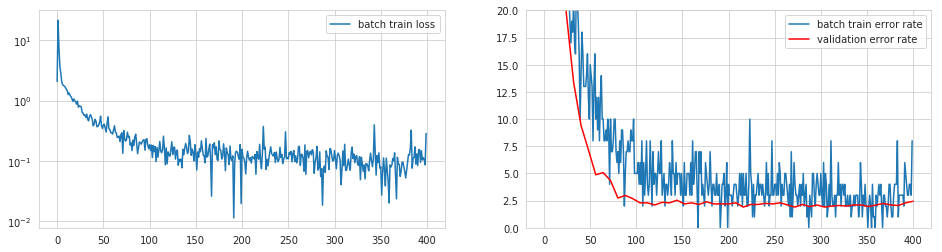

In [3]:
net = alexnet(pretrained=True)

for param in net.parameters():
    param.requires_grad = False
    
net.classifier = alex_classifier(8)

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.classifier.parameters(), lr=0.001)

train(net, batch_loader, optimizer, criterion, num_epochs = 50, cuda = cuda)

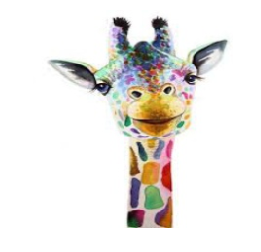

In [4]:
num = 800
ds.plot_img(num, 'train')

In [5]:
print('prediction : ' , pac_label_to_string(net.forward(ds.item(num, 'train')[0][None,:].cuda()).max(dim=1)[1][0]))

save_model(net, 'pacs_art')

prediction :  giraffe


# PACS CARTOON

In [9]:
ds = datasets()
ds.create_dataset('pacs', pacs='cartoon')
batch_loader = ds.batch_loader(256)

Training the model!
Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
You can interrupt it at any time.
----------------------------------------------------------
After epoch  1 | valid err rate: 45.52% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate: 21.37% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate: 11.56% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  9.22% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  4.

----------------------------------------------------------
After epoch 46 | valid err rate:  1.28% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 47 | valid err rate:  1.15% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 48 | valid err rate:  1.24% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 49 | valid err rate:  1.11% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 50 | valid err rate:  1.07% | doing  50 epochs
----------------------------------------------------------


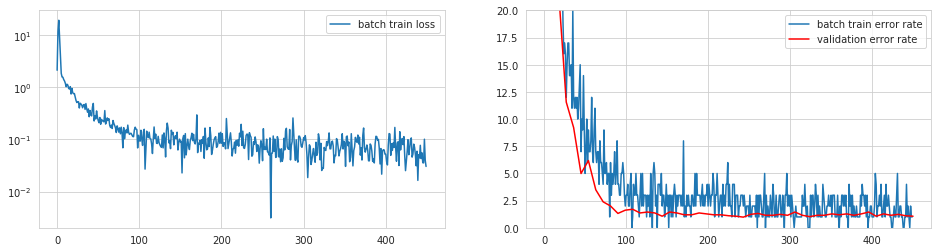

In [10]:
net = alexnet(pretrained=True)

for param in net.parameters():
    param.requires_grad = False
    
net.classifier = alex_classifier(8)

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.classifier.parameters(), lr=0.001)

train(net, batch_loader, optimizer, criterion, num_epochs = 50, cuda = cuda)

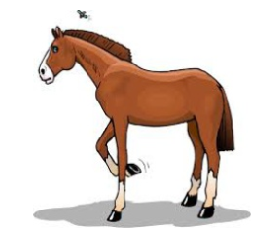

In [11]:
num = 1200
ds.plot_img(num, 'train')

In [12]:
print('prediction : ' , pac_label_to_string(net.forward(ds.item(num, 'train')[0][None,:].cuda()).max(dim=1)[1][0]))

save_model(net, 'pacs_cartoon')

prediction :  horse


# PACS PHOTO

In [13]:
ds = datasets()
ds.create_dataset('pacs', pacs='photo')
batch_loader = ds.batch_loader(256)

Training the model!
Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
You can interrupt it at any time.
----------------------------------------------------------
After epoch  1 | valid err rate: 38.98% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate: 21.38% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate: 13.71% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  8.32% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate:  4.

----------------------------------------------------------
After epoch 46 | valid err rate:  0.84% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 47 | valid err rate:  1.08% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 48 | valid err rate:  1.08% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 49 | valid err rate:  1.14% | doing  50 epochs
----------------------------------------------------------
Minibatch    300  | loss  0.02 | err rate  0.00%
----------------------------------------------------------
After epoch 50 | valid err rate:  1.08% | doing  50 epochs
----------------------------------------------------------


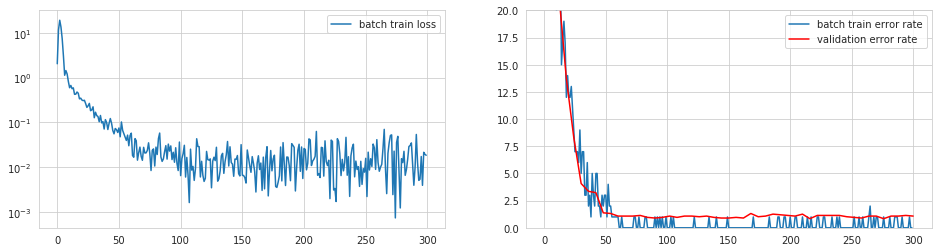

In [14]:
net = alexnet(pretrained=True)

for param in net.parameters():
    param.requires_grad = False
    
net.classifier = alex_classifier(8)

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.classifier.parameters(), lr=0.001)

train(net, batch_loader, optimizer, criterion, num_epochs = 50, cuda = cuda)

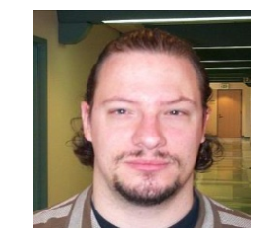

In [15]:
num = 1200
ds.plot_img(num, 'train')

In [16]:
print('prediction : ' , pac_label_to_string(net.forward(ds.item(num, 'train')[0][None,:].cuda()).max(dim=1)[1][0]))

save_model(net, 'pacs_photo')

prediction :  person


# PACS SKTECH

In [17]:
ds = datasets()
ds.create_dataset('pacs', pacs='sketch')
batch_loader = ds.batch_loader(256)

Training the model!
Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias
You can interrupt it at any time.
----------------------------------------------------------
After epoch  1 | valid err rate: 37.59% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate: 22.45% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate: 16.09% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate: 10.72% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 | valid err rate: 10.

----------------------------------------------------------
After epoch 45 | valid err rate:  1.68% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 46 | valid err rate:  1.86% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 47 | valid err rate:  1.88% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 48 | valid err rate:  1.78% | doing  50 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch 49 | valid err rate:  1.86% | doing  50 epochs
----------------------------------------------------------
Minibatch    700  | loss  0.10 | err rate  3.00%
----------------------------------------------------------
After e

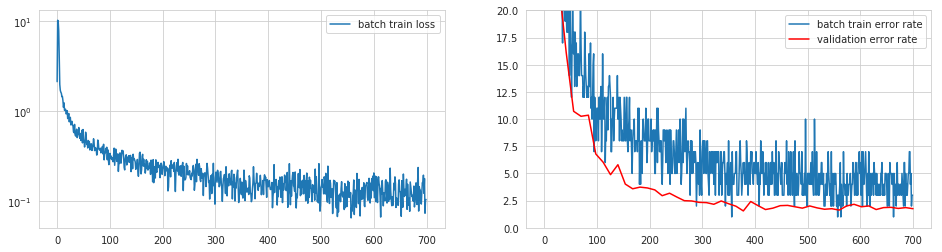

In [18]:
net = alexnet(pretrained=True)

for param in net.parameters():
    param.requires_grad = False
    
net.classifier = alex_classifier(8)

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.classifier.parameters(), lr=0.001)

train(net, batch_loader, optimizer, criterion, num_epochs = 50, cuda = cuda)

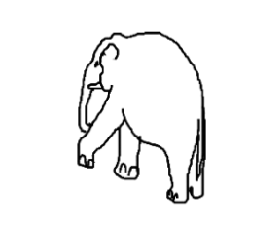

In [19]:
num = 1200
ds.plot_img(num, 'train')

In [20]:
print('prediction : ' , pac_label_to_string(net.forward(ds.item(num, 'train')[0][None,:].cuda()).max(dim=1)[1][0]))

save_model(net, 'pacs_sketch')

prediction :  elephant
